### Здесь у меня проблемы с путями, может быть вы свежим взглядом увидете что-то

In [1]:
from nilearn import plotting
%matplotlib inline
import json

# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')


/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
with open('../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']
print(TR)

1.5


# Workflow

In [3]:
# Create workflow
preproc = Workflow(name='work_preproc', base_dir='../../fmri_combined/')

In [4]:
! ls ../../fmri_combined/fmriprep/sub-t06/func/

sub-t06_task-rest_bold.json  sub-t06_task-rest_bold.nii.gz


# Gunzip

In [5]:
from nipype.algorithms.misc import Gunzip

# Specify input file
func_file = '../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.nii.gz'

# Initiate Gunzip node
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

In [6]:
gunzip_func.inputs


in_file = ../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.nii.gz

In [7]:
import os

if os.path.exists(func_file):
    res = gunzip_func.run()

220209-22:17:41,702 nipype.workflow INFO:
	 [Node] Setting-up "gunzip_func" in "/tmp/tmpc1ucgft_/gunzip_func".
220209-22:17:41,706 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
220209-22:17:41,711 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.000119s.
220209-22:17:41,712 nipype.workflow WARNING:
	 Storing result file without outputs
220209-22:17:41,714 nipype.workflow WARNING:
	 [Node] Error on "gunzip_func" (/tmp/tmpc1ucgft_/gunzip_func)


NodeExecutionError: Exception raised while executing Node gunzip_func.

Traceback (most recent call last):
  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/algorithms/misc.py", line 309, in _run_interface
    with gzip.open(self.inputs.in_file, "rb") as in_file:
  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/gzip.py", line 58, in open
    binary_file = GzipFile(filename, gz_mode, compresslevel)
  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/gzip.py", line 168, in __init__
    fileobj = self.myfileobj = builtins.open(filename, mode or 'rb')
FileNotFoundError: [Errno 2] No such file or directory: '../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.nii.gz'


- **Check file**

In [8]:
os.path.exists('../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.nii.gz')

True

In [9]:
import gzip
import shutil
with gzip.open(func_file, 'rb') as f_in:
    with open(func_file.replace('.gz', ''), 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [10]:
!ls ../../fmri_combined/fmriprep/sub-t06/func/

sub-t06_task-rest_bold.json  sub-t06_task-rest_bold.nii.gz
sub-t06_task-rest_bold.nii


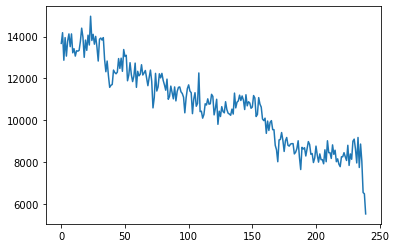

In [11]:
# Full time series
import nibabel as nb
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :])

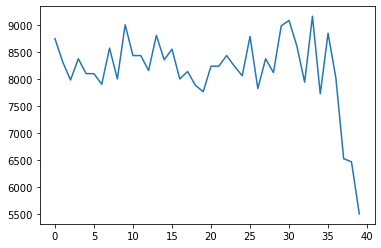

In [12]:
# End of time series
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, 200:])

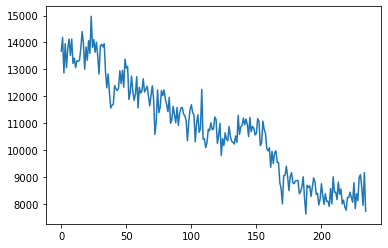

In [13]:
# Cropped time series
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :235])

# Drop Dummy Scans

In [14]:
from nipype.interfaces.fsl import ExtractROI

extract = Node(ExtractROI(t_min=0, t_size=-1, output_type='NIFTI'),
               name="extract")

preproc.connect([(gunzip_func, extract, [('out_file', 'in_file')])])

In [15]:
extract.outputs


roi_file = <undefined>

# Slice Time Correction

In [16]:
from nipype.interfaces.fsl import SliceTimer

slicetime = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetime")
    
preproc.connect([(extract, slicetime, [('roi_file', 'in_file')])])

In [17]:
slicetime.outputs


slice_time_corrected_file = <undefined>

# Motion Correction

In [18]:
from nipype.interfaces.fsl import MCFLIRT

mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

preproc.connect([(slicetime, mcflirt, [('slice_time_corrected_file', 'in_file')])])

In [19]:
mcflirt.outputs


mat_file = <undefined>
mean_img = <undefined>
out_file = <undefined>
par_file = <undefined>
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

# Artifact Detection

-    norm_threshold - Threshold to use to detect motion-related outliers when composite motion is being used
-    zintensity_threshold - Intensity Z-threshold use to detection images that deviate from the mean
-    mask_type - Type of mask that should be used to mask the functional data. spm_global uses an spm_global like calculation to determine the brain mask
-    parameter_source - Source of movement parameters
-    use_differences - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers


In [20]:
from nipype.algorithms.rapidart import ArtifactDetect


art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")


preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

# Segmentation of anatomical image

In [21]:
! ls ../../fmri_combined/fmriprep/sub-t06/anat/

sub-t06_T1w.json  sub-t06_T1w.nii.gz


In [22]:
from nipype.interfaces.spm import NewSegment

# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

segment = Node(NewSegment(tissues=tissues), name='segment')


# Specify anat input file
anat_file = '../../fmri_combined/fmriprep/sub-t06/anat/sub-t06_T1w.nii.gz'

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')

preproc.connect([(gunzip_anat, segment, [('out_file', 'channel_files')])])

stty: 'standard input': Inappropriate ioctl for device


In [23]:
segment.outputs


bias_corrected_images = <undefined>
bias_field_images = <undefined>
dartel_input_images = <undefined>
forward_deformation_field = <undefined>
inverse_deformation_field = <undefined>
modulated_class_images = <undefined>
native_class_images = <undefined>
normalized_class_images = <undefined>
transformation_mat = <undefined>

# Compute Coregistration Matrix

In [24]:
from nipype.interfaces.fsl import FLIRT

coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

preproc.connect([(gunzip_anat, coreg, [('out_file', 'reference')]),
                 (mcflirt, coreg, [('mean_img', 'in_file')])
                 ])

In [25]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")



In [26]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

# Connecting the segmentation node with the threshold node
preproc.connect([(segment, threshold_WM, [(('native_class_images', get_wm),
                                           'in_file')])])

preproc.connect([(threshold_WM, coreg, [('out_file', 'wm_seg')])])

# Apply Coregistration Matrix to functional image

In [27]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

In [28]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(mcflirt, applywarp, [('out_file', 'in_file')]),
                 (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (gunzip_anat, applywarp, [('out_file', 'reference')])
                 ])

# Smoothing

In [29]:
from niflow.nipype1.workflows.fmri.fsl.preprocess import create_susan_smooth

susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4



preproc.connect([(applywarp, susan, [('out_file', 'inputnode.in_files')])])

In [30]:
from nipype.interfaces.fsl import FLIRT

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

In [31]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

In [32]:
preproc.connect([(segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                      ]),
                 (resample, mask_GM, [('out_file', 'in_file')])
                 ])


# Apply the binary mask

In [33]:
preproc.connect([(mask_GM, susan, [('out_file', 'inputnode.mask_file')])])

In [34]:
from nipype.interfaces.fsl import ApplyMask
from nipype import MapNode

mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

preproc.connect([(susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')])
                 ])


# Remove linear trends in functional images

In [35]:
from nipype.algorithms.confounds import TSNR

detrend = Node(TSNR(regress_poly=2), name="detrend")

preproc.connect([(mask_func, detrend, [('out_file', 'in_file')])])

# Visualize workflow

220209-22:18:37,847 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/functional_connectivity/fmri_combined/work_preproc/graph.png (graph2use=flat, simple_form=True).


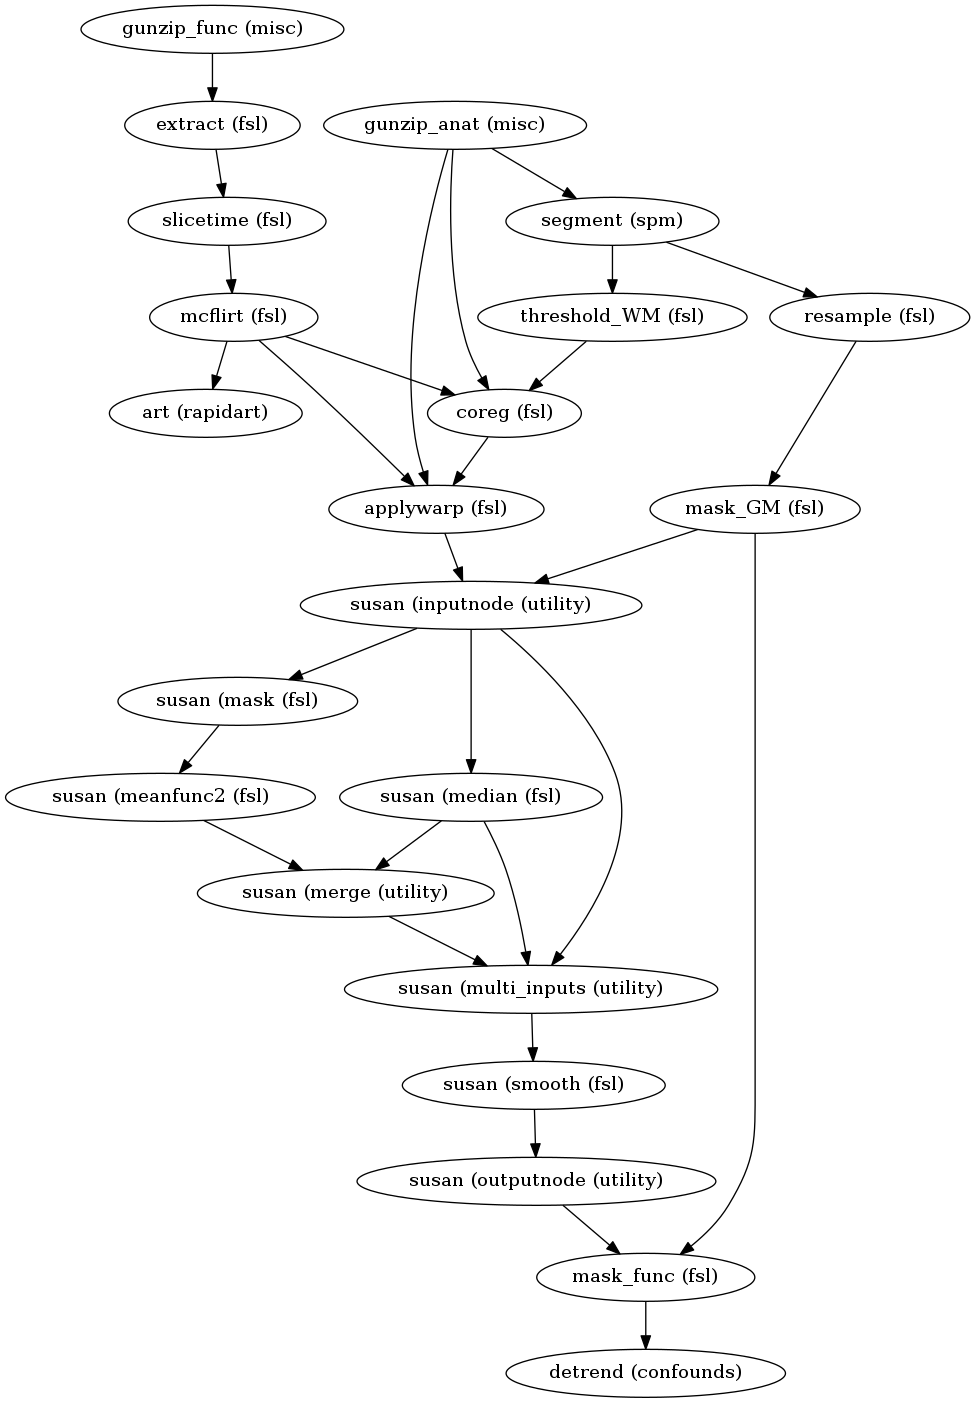

In [36]:
from IPython.display import Image
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename='../../fmri_combined/work_preproc/graph.png')

In [37]:
!ls ../../fmri_combined/fmriprep/sub-t06/func/

sub-t06_task-rest_bold.json  sub-t06_task-rest_bold.nii.gz
sub-t06_task-rest_bold.nii


In [38]:
preproc.run('MultiProc', plugin_args={'n_procs': 2})

220209-22:18:38,779 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
220209-22:18:38,807 nipype.workflow INFO:
	 Running in parallel.
220209-22:18:38,813 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 10.45/10.45, Free processors: 2/2.
220209-22:18:39,24 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_func" in "/tmp/tmpc1ucgft_/gunzip_func".
220209-22:18:39,25 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_anat" in "/home/neuro/functional_connectivity/fmri_combined/work_preproc/gunzip_anat".
220209-22:18:39,30 nipype.workflow INFO:
	 [Node] Executing "gunzip_func" <nipype.algorithms.misc.Gunzip>
220209-22:18:39,37 nipype.workflow INFO:
	 [Node] Executing "gunzip_anat" <nipype.algorithms.misc.Gunzip>
220209-22:18:39,35 nipype.workflow INFO:
	 [Node] Finished "gunzip_func", elapsed time 0.00016s.
220209-22:18:39,41 nipype.workflow WARNING:
	 Storing result file 

RuntimeError: 2 raised. Re-raising first.

In [39]:
from nilearn import image as nimg
from nilearn import plotting as nplot
import nibabel as nib

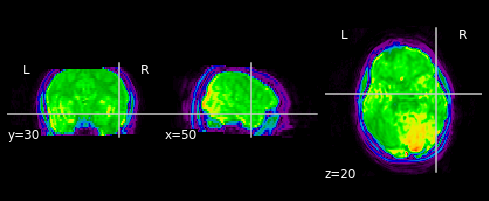

In [40]:
func_img_s6 = nib.load('../../fmri_combined/fmriprep/sub-t06/func/sub-t06_task-rest_bold.nii.gz')
func_vol5_s6 = func_img_s6.slicer[:,:,:,6]
nplot.plot_epi(func_vol5_s6, cut_coords=(50,30,20))

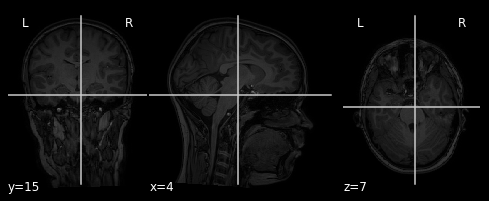

In [41]:
mean_img = nib.load('../../fmri_combined/fmriprep/sub-t06/anat/sub-t06_T1w.nii.gz')
nplot.plot_anat(mean_img)

In [42]:
from nipype.utils.filemanip import loadpkl
res = loadpkl('crash-20220209-220444-neuro-gunzip_func-5c3dbc56-a436-4e00-966c-da81d1fe5703.pklz')

In [43]:
res

{'node': work_preproc.gunzip_func,
 'traceback': ['Traceback (most recent call last):\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node\n    result["result"] = node.run(updatehash=updatehash)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 524, in run\n    result = self._run_interface(execute=True)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 642, in _run_interface\n    return self._run_command(execute)\n',
  '  File "/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/nipype/pipeline/engine/nodes.py", line 751, in _run_command\n    f"Exception raised while executing Node {self.name}.\\n\\n{result.runtime.traceback}"\n',
  'nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node gunzip_func.\n\nTraceback (most recent call last)